# 1D Beam–Plasma (Bump-on-Tail) Updated Prototype

Roadmap:

1. Define physical constants and design the beam + background + resonance (set $k$ so that $v_φ = ωₚ / k$ sits on the beam slope).
2. Specify simulation and fitting parameters.
3. Run a **single main simulation** with many particles and long time.
4. Automatically detect:
   - saturation time t_sat,
   - a late non-linear time $t_{lateNL} ≈ t_{sat} + 8 τ_B$.
5. Build approximate Maxwellian PDFs for the beam at:
   - early linear time (“early”),
   - late linear time (“late-L”),
   - late non-linear time (“late-NL”),
   and compute $Δf(v) = f_{lateNL} − f_{early}$.
6. Plot:
   - $|E|(t)$ with an interactive linear-fit window selector,
   - Beam PDFs and $Δf(v)$ relative to the resonance velocity $v_φ$.


## Imports
NumPy for arrays, Matplotlib for plotting, `tqdm` for progress bars,
and `SpanSelector` for interactive window selection on the $|E|(t)$ plot.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.widgets import SpanSelector
from scipy import special  # reserved for later if we need special functions

%matplotlib widget

import matplotlib
print("Backend:", matplotlib.get_backend())


Backend: widget


## Physical constants
For now we non-dimensionalize so that ωₚ, e, and mₑ are all 1. These can be
rescaled later when we want more realistic units.

In [2]:
# =========================== PHYSICS CONSTANTS =============================
omega_p  = 1.0
e_charge = 1.0
m_e      = 1.0

## Beam and resonance design

We define:
- `ub_target`: beam mean velocity (location of the bump).
- `vb_target`: beam thermal speed / spread (the beam Maxwellian width).
- `alpha`: how far to the *left* of the beam mean we place the phase velocity `v_phi`,
  in units of `vb` (so `v_phi = u_b − alpha * v_b`).

Then we solve for `k` from `v_phi = ω_p / k` and define the domain length `L = 2π / k`.


In [5]:
##### BEAM & RESONANCE DESIGN #####

ub_target = 1.20     # beam mean (peak of Maxwellian)
vb_target = 0.30     # beam thermal spread (std)
alpha     = 0.80     # how far left (in sigmas) we want v_phi from the mean; 0 < alpha < 1

# Phase velocity design: v_phi < ub and within ~1σ
vphi_target = ub_target - alpha * vb_target
k           = omega_p / vphi_target          # so that v_phi = omega_p/k = vphi_target
v_phi       = omega_p / k
L           = 2.0 * np.pi / k

## Normalization and main simulation parameters

- We normalize velocities to the **background thermal speed** `v_th = 1`, so the
  reference Maxwellian is `N(0,1)`.
- In this notebook we **advance only the beam macroparticles**. The remaining
  `1 - nb_true` background is treated as an immobile neutralizing component
  (it does not contribute to the current in our present case).


In [6]:
# Normalization: background thermal speed v_th = 1 (Maxwellian N(0,1))
v_th = 1.0

##### SIMULATION PARAMETERS #####
PARAMS = dict(
    nb_true=0.1920,          # beam density fraction (0<nb<1)
    ub=ub_target,            # beam mean in units of v_th
    vb=vb_target,            # beam thermal speed in units of v_th
    dt=0.1,
    N_total=30000,           # main particle count (beam macroparticles)
    E_amp=4.27e-06,          # initial field amplitude
    Nx_grid=256,             # uniform grid resolution for scatter/gather
)


## Run / fit controls

We fix:
- total time for short and full runs,
- controls for the linear-fit algorithm (window sizes, R² threshold),
- sampling cadence for PDFs,
- RNG seed for reproducibility.

In [7]:
##### RUN / FIT CONTROLS #####
seed        = 42
tmax_full   = 6000.0       # total time for full-quality run
tmax_short  = 800.0        # total time for short diagnostic run

FIT_BOUNDS  = None         # can be set interactively later
prefer_earliest_window = True
min_pts_for_fit = 40
R2_THRESH   = 0.85
W_list_candidates = [60.0, 80.0, 100.0, 120.0, 240.0]  # candidate fit-window lengths
scan_seconds_short = 2.0
scan_seconds_full  = 2.0

# For the PDF stage sampling windows
halfwin      = 5.0         # half-width around target times for sampling PDFs
sample_every = 8           # sample velocities every N time steps

# RNG
rng = np.random.default_rng(seed)

In [8]:
##### MAIN RUN (beam-only) #####
nb_true_f  = float(PARAMS['nb_true'])
ub_f       = float(PARAMS['ub'])
vb_f       = float(PARAMS['vb'])
dt_f       = float(PARAMS['dt'])
E_amp_f    = float(PARAMS['E_amp'])
N_beam_f   = int(PARAMS['N_total'])
Nx_grid    = int(PARAMS.get('Nx_grid', 256))


### Particle numbers and initial distributions (full run)

We choose:
- a large `N_plot` (at least `N_total_f`),
- beam and background particle counts,
then draw velocities and positions as before.

In [ ]:
# Beam macroparticles (beam-only advance)
v_full = ub_f + vb_f * rng.standard_normal(N_beam_f)
x_full = L * rng.random(N_beam_f)

# Weights represent density fractions; sum(w_beam) = nb_true
w_full = np.full(N_beam_f, nb_true_f / max(1, N_beam_f))

idx_beam_full = np.arange(N_beam_f, dtype=int)

# Uniform grid for scatter/gather
xg = (np.arange(Nx_grid) + 0.5) * (L / Nx_grid)   # cell centers
dx = L / Nx_grid


### Leapfrog initialization and storage (full run)

We set up the leapfrog half-step velocities and allocate:
- `E_hist_full`, `t_hist_full` to store $|E|(t)$,
- sampling lists for velocities at different times for the beam and background.

In [ ]:
def cic_gather(field_g, x_p, L, dx):

    """CIC gather from uniform grid at cell centers."""

    Nx = field_g.size
    # shift so index 0 corresponds to x = dx/2
    xi = (x_p / dx) - 0.5
    i0 = np.floor(xi).astype(int)
    frac = xi - i0
    i0_mod = i0 % Nx
    i1_mod = (i0 + 1) % Nx
    return (1.0 - frac) * field_g[i0_mod] + frac * field_g[i1_mod]


def cic_scatter(values_p, x_p, L, dx, Nx):

    """CIC scatter values (e.g. current) from particles to grid at cell centers."""

    grid = np.zeros(Nx, dtype=float)
    xi = (x_p / dx) - 0.5
    i0 = np.floor(xi).astype(int)
    frac = xi - i0
    i0_mod = i0 % Nx
    i1_mod = (i0 + 1) % Nx
    np.add.at(grid, i0_mod, (1.0 - frac) * values_p)
    np.add.at(grid, i1_mod, frac * values_p)
    return grid


# Initialize leapfrog half-step velocities using grid-gathered E(x)
E_grid = E_amp_f * np.cos(k * xg - omega_p * 0.0)
E0_p   = cic_gather(E_grid, x_full, L, dx)
vhalf_full  = v_full - 0.5 * dt_f * (e_charge / m_e) * E0_p

nsteps_full = max(1, int(round(tmax_full / dt_f)))
E_hist_full = np.empty(nsteps_full, dtype=float)
t_hist_full = np.empty(nsteps_full, dtype=float)
time_full   = 0.0


# Sampling storage for PDFs (beam only)
v_samps_beam_full   = []
w_samps_beam_full   = []
t_samp_full         = []


### Full run loop

Each time step:
1. Update velocities and positions using leapfrog.
2. Update the field amplitude from the current.
3. Every `sample_every` steps, store:
   - a random subset of all particles,
   - separate subsets for beam and background (for PDFs).

In [ ]:
for step_full in tqdm(range(nsteps_full), desc="Main run (grid scatter/gather)", ncols=90):
    # record |E|
    E_hist_full[step_full] = abs(E_amp_f)
    t_hist_full[step_full] = time_full

    ### field on grid and gathered to particles ###
    E_grid = E_amp_f * np.cos(k * xg - omega_p * time_full)
    E_p    = cic_gather(E_grid, x_full, L, dx)

    ### leapfrog kick ###
    vhalf_new = vhalf_full - (e_charge / m_e) * E_p * dt_f
    v_cent    = 0.5 * (vhalf_full + vhalf_new)

    ### drift ###
    x_full = (x_full + vhalf_new * dt_f) % L

    ### sample beam velocities (centered) ###
    if (step_full % sample_every) == 0:
        ns = min(20000, v_cent.size)
        idx = rng.permutation(v_cent.size)[:ns]
        v_samps_beam_full.append(v_cent[idx])
        w_samps_beam_full.append(w_full[idx])
        t_samp_full.append(time_full)


    #### scatter current to grid, then project to k-mode and update E_amp ####

    # particle current contributions (density fraction weights)
    Jp = w_full * v_cent                      # (dimensionless current per particle)
    Jg = cic_scatter(Jp, x_full, L, dx, Nx_grid) / dx  # current density on grid

    # project onto cos(kx - ωt)
    J_k = (-e_charge) * (2.0 / L) * np.sum(Jg * np.cos(k * xg - omega_p * time_full)) * dx

    # field amplitude evolution
    E_amp_f = E_amp_f - (e_charge / (m_e * omega_p)) * J_k * dt_f

    vhalf_full = vhalf_new
    time_full += dt_f

t_samp_full = np.array(t_samp_full)


Main run (grid scatter/gather): 100%|███████████████| 60000/60000 [15:14<00:00, 65.59it/s]


## Linear fit on full run

We repeat the sliding-window linear fit on `log|E|` for the full run.
Optional `FIT_BOUNDS` can restrict the time interval before fitting.

In [12]:
mask_fit_full = (E_hist_full > 0.0)
t_fit_base_full = t_hist_full[mask_fit_full]
logE_fit_base_full = np.log(E_hist_full[mask_fit_full])

if FIT_BOUNDS is not None:
    lo_b, hi_b = FIT_BOUNDS
    mask_bounds = (t_fit_base_full >= lo_b) & (t_fit_base_full <= hi_b)
    t_fit_base_full    = t_fit_base_full[mask_bounds]
    logE_fit_base_full = logE_fit_base_full[mask_bounds]

fit_full = None
if t_fit_base_full.size >= min_pts_for_fit:
    if t_fit_base_full.size > 1:
        dt_eff_full = max(1e-9, t_fit_base_full[1] - t_fit_base_full[0])
    else:
        dt_eff_full = 1.0
    step_incr_full = max(1, int(round(scan_seconds_full / dt_eff_full)))

    for W_try in W_list_candidates:
        i0_full = 0
        while (
            i0_full < t_fit_base_full.size and
            (t_fit_base_full[i0_full] + W_try) <= t_fit_base_full[-1]
        ):
            sel_full = (
                (t_fit_base_full >= t_fit_base_full[i0_full]) &
                (t_fit_base_full <= t_fit_base_full[i0_full] + W_try)
            )
            if np.count_nonzero(sel_full) >= 25:
                tt = t_fit_base_full[sel_full]
                yy = logE_fit_base_full[sel_full]
                A  = np.vstack([tt, np.ones_like(tt)]).T
                c  = np.linalg.lstsq(A, yy, rcond=None)[0]
                gamma_try = c[0]
                yhat_try  = A @ c
                ssr = np.sum((yy - yhat_try) ** 2)
                sst = np.sum((yy - np.mean(yy)) ** 2)
                r2  = 1.0 - ssr / max(1e-12, sst)

                if (r2 >= R2_THRESH) and (gamma_try > 0.0):
                    fit_full = dict(
                        gamma=gamma_try, r2=r2,
                        t0=tt[0], t1=tt[-1],
                        twin=tt, yhat=yhat_try,
                    )
                    if prefer_earliest_window:
                        break
            i0_full += step_incr_full
        if fit_full and prefer_earliest_window:
            break

if not fit_full:
    print("No clean positive-slope linear window found in the requested bounds.")
else:
    print(f"[full] gamma={fit_full['gamma']:.4e}, R^2={fit_full['r2']:.3f}, "
          f"window=[{fit_full['t0']:.0f},{fit_full['t1']:.0f}]")

[full] gamma=1.2287e-01, R^2=0.956, window=[0,60]


## Sampling windows and concatenation helper

We define a small utility to concatenate sampled velocities and weights over
a list of time-window indices.

In [13]:
def _concat_from_indices(lst_v, lst_w, idxs):
    if idxs.size == 0:
        return np.array([]), np.array([])
    V = np.concatenate([lst_v[i] for i in idxs]) if len(idxs) > 0 else np.array([])
    W = np.concatenate([lst_w[i] for i in idxs]) if len(idxs) > 0 else np.array([])
    return V, W

### Saturation detection and late-NL time

We compute a **local slope** of `log|E|` using a moving window of width `win`.
When the slope stays near 0 for a long enough streak (`SAT_STREAK`), we interpret
that as saturation time `t_sat`.

Then we compute:
- $E_{sat} = |E|(t_{sat})$,
- bounce frequency: $ω_B ≈ √(e k E_{sat} / m)$,
- bounce period: $τ_B = 2π / ω_B$,
- late non-linear time: $t_{lateNL} = t_{sat} + 8 τ_B$ (≈ 8 bounce periods after saturation).

In [14]:
# ---- detect saturation and pick a genuinely late-NL time ----
win    = 60.0                 # seconds for local regression window
dt_eff = t_hist_full[1] - t_hist_full[0]
Wn     = max(5, int(round(win / dt_eff)))

logE   = np.log(np.clip(E_hist_full, 1e-12, None))
slopes = np.full_like(logE, np.nan, dtype=float)
Acol   = np.vstack([np.arange(Wn)*dt_eff, np.ones(Wn)]).T  # local time basis

for i in range(Wn, len(logE)):
    y = logE[i-Wn:i]
    c = np.linalg.lstsq(Acol, y, rcond=None)[0]
    slopes[i] = c[0]  # local d/dt log|E|

# saturation = first time slope magnitude stays small
SLOPE_EPS  = 5e-3
SAT_STREAK = max(5, int(round(40.0 / dt_eff)))  # require ~40 s of small slope
sat_idx    = None
for i in range(Wn, len(slopes) - SAT_STREAK):
    seg = slopes[i:i+SAT_STREAK]
    if np.all(np.isfinite(seg)) and np.all(np.abs(seg) < SLOPE_EPS):
        sat_idx = i
        break

if sat_idx is None:
    # fallback: just take global max E as “near saturation”
    sat_idx = int(np.argmax(E_hist_full))

t_sat = t_hist_full[sat_idx]

# Bounce frequency and late-NL sampling time
E_sat   = abs(E_hist_full[sat_idx])
omega_B = np.sqrt((e_charge * k * E_sat) / m_e) if E_sat > 0 else 0.0
tau_B   = (2*np.pi / omega_B) if omega_B > 0 else 100.0
t_lateNL = t_sat + 8.0 * tau_B   # ~8 bounce periods past saturation

### Choose sampling windows around (early, late-L, late-NL)

We use:
- early reference time: `t_early_ref = t₀` from the linear fit (if available),
- late linear reference: `t_lateL_ref = t₁`,
- late-NL reference: `t_lateNL` from bounce-based estimate.

Around each reference time, we pick all sampling times within ±`halfwin`.

In [15]:
if fit_full:
    t_early_ref = fit_full['t0']
    t_lateL_ref = fit_full['t1']
else:
    t_early_ref = 0.0
    t_lateL_ref = t_sat

early_idx_sel  = np.where(np.abs(t_samp_full - t_early_ref) <= halfwin)[0]
lateL_idx_sel  = np.where(np.abs(t_samp_full - t_lateL_ref) <= halfwin)[0]
lateNL_idx_sel = np.where(np.abs(t_samp_full - t_lateNL) <= halfwin)[0]

print(f"[windows] t_sat≈{t_sat:.1f}, tau_B≈{tau_B:.1f}, lateNL at t≈{t_lateNL:.1f}")
print(f"   early samples  : {len(early_idx_sel)} windows")
print(f"   late-L samples : {len(lateL_idx_sel)} windows")
print(f"   late-NL samples: {len(lateNL_idx_sel)} windows")

# concatenate beam samples for PDFs
vb0_all,  wb0_all  = _concat_from_indices(v_samps_beam_full, w_samps_beam_full, early_idx_sel)
vbL_all,  wbL_all  = _concat_from_indices(v_samps_beam_full, w_samps_beam_full, lateL_idx_sel)
vbNL_all, wbNL_all = _concat_from_indices(v_samps_beam_full, w_samps_beam_full, lateNL_idx_sel)

[windows] t_sat≈375.5, tau_B≈4.4, lateNL at t≈410.8
   early samples  : 7 windows
   late-L samples : 13 windows
   late-NL samples: 12 windows


## Maxwellian fits for the beam

We approximate the beam at each stage (early, late-L, late-NL) by a Gaussian
with:
- mean $μ = ⟨v⟩$,
- standard deviation $σ = √⟨(v − μ)²⟩$,

computed using the particle weights. Then we evaluate these Gaussians on a
common velocity grid to define f_early, f_lateL, and f_lateNL.

In [16]:
def _weighted_moments(v, w):
    """Return (mu, sigma) using normalized weights w."""
    if v.size == 0:
        return np.nan, np.nan
    w = w / max(np.finfo(float).eps, np.sum(w))
    mu = np.sum(w * v)
    s2 = np.sum(w * (v - mu)**2)
    return mu, np.sqrt(max(s2, 0.0))

def _gaussian_pdf(vg, mu, sigma):
    sigma = max(sigma, 1e-6)
    return np.exp(-0.5*((vg-mu)/sigma)**2) / (np.sqrt(2*np.pi)*sigma)

### Compute Gaussian parameters and set a velocity grid

We:
1. Compute $(μ, σ)$ for early, late-L, late-NL using the beam samples.
2. Fall back to $(u_b, v_b)$ if we don't have finite values.
3. Build a velocity grid that spans several $σ$ around all three means plus $v_φ$.

In [17]:
# use sample moments if available; otherwise fall back to PARAMS
mu0, s0 = _weighted_moments(vb0_all,  wb0_all)
muL, sL = _weighted_moments(vbL_all,  wbL_all)
muN, sN = _weighted_moments(vbNL_all, wbNL_all)

if not np.isfinite(mu0): mu0, s0 = ub_f, vb_f
if not np.isfinite(muL): muL, sL = ub_f, vb_f
if not np.isfinite(muN): muN, sN = ub_f, vb_f

print("mu0, s0 =", mu0, s0)
print("muL, sL =", muL, sL)
print("muN, sN =", muN, sN)
print("v_phi   =", v_phi)

# NEW: cap sigmas for plotting so one crazy stage doesn't blow the axis
sigma_plot_cap = 5.0  # max sigma we'll let control the axis (tunable)

def _sigma_for_plot(s, fallback):
    if not np.isfinite(s):
        return fallback
    return min(s, sigma_plot_cap)

s0_plot = _sigma_for_plot(s0, vb_f)
sL_plot = _sigma_for_plot(sL, vb_f)
sN_plot = _sigma_for_plot(sN, vb_f)

sigma_max_for_grid = max(s0_plot, sL_plot, sN_plot, vb_f)

mu_min = min(mu0, muL, muN, v_phi)
mu_max = max(mu0, muL, muN, v_phi)

vg_min = mu_min - 4.0 * sigma_max_for_grid
vg_max = mu_max + 4.0 * sigma_max_for_grid

vg_grid = np.linspace(vg_min, vg_max, 900)

# Maxwellian PDFs using the true (unclipped) sigmas
pdf_early_beam  = _gaussian_pdf(vg_grid, mu0, s0)
pdf_lateL_beam  = _gaussian_pdf(vg_grid, muL, sL)
pdf_lateNL_beam = _gaussian_pdf(vg_grid, muN, sN)


mu0, s0 = 1.2016548923278885 0.3010988563595124
muL, sL = 1.0601558862912033 0.41546618980658157
muN, sN = 0.9574863522910156 0.920819055251558
v_phi   = 0.96


## Plot |E|(t) with interactive linear fit

We plot $|E|(t)$ on a semilog scale and attach a `SpanSelector` so that:
- dragging with the mouse selects a time window [t₀, t₁],
- the code fits $log|E|$ in that window,
- it overlays the fit and prints γ and R²,
- pressing **S** saves the chosen window as `FIT_BOUNDS`,
- pressing **R** resets the selection.

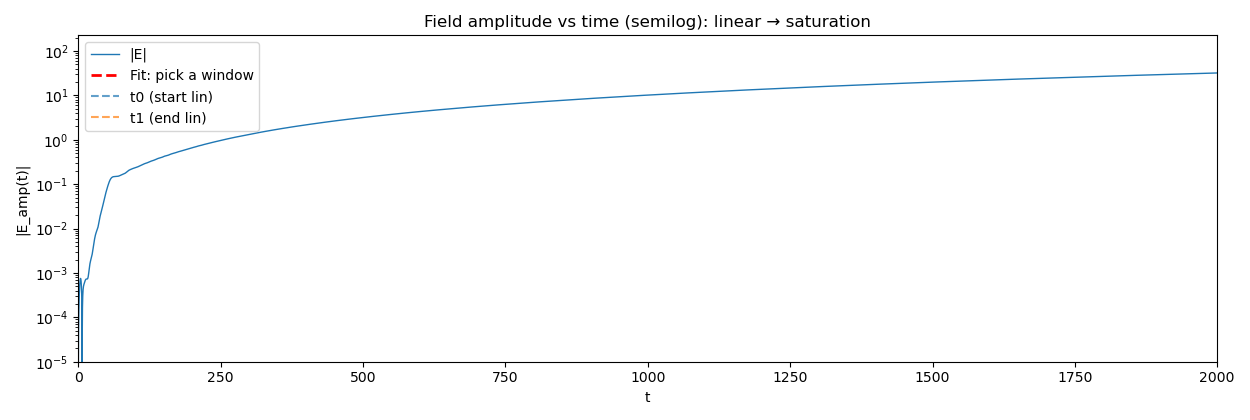

In [18]:
mask_fit_full        = (E_hist_full > 0.0)
t_fit_base_full      = t_hist_full[mask_fit_full]
logE_fit_base_full   = np.log(E_hist_full[mask_fit_full])

figA = plt.figure(figsize=(12.5, 4.2))
axA  = figA.add_subplot(1, 1, 1)

# main curve
lineE, = axA.semilogy(t_hist_full, E_hist_full, lw=1.0, label='|E|')
axA.set_ylim(1e-5, 1.2*np.max(E_hist_full))
axA.set_xlim(0, 2000)
axA.set_title('Field amplitude vs time (semilog): linear → saturation')
axA.set_xlabel('t')
axA.set_ylabel('|E_amp(t)|')

# Placeholders that will be updated by interactions
fit_line, = axA.semilogy([], [], 'r--', lw=2.0, label='Fit: pick a window')
v_t0 = axA.axvline(np.nan, ls='--', color='tab:blue',   alpha=0.7, label='t0 (start lin)')
v_t1 = axA.axvline(np.nan, ls='--', color='tab:orange', alpha=0.7, label='t1 (end lin)')
leg  = axA.legend(loc='best')

# State to carry results out of the callback
gamma_fit = None
r2_fit    = None
t0_sel    = None
t1_sel    = None

def _update_legend_text(gamma, r2):
    fit_label = (
        f"Fit: γ={gamma:.3e}, R²={r2:.3f}"
        if (gamma is not None) else
        "Fit: pick a window"
    )
    fit_line.set_label(fit_label)
    axA.legend_.remove()
    axA.legend(loc='best')

def _do_fit(t0, t1):
    global gamma_fit, r2_fit, t0_sel, t1_sel
    if t0 > t1:
        t0, t1 = t1, t0

    sel = (t_fit_base_full >= t0) & (t_fit_base_full <= t1)
    if np.count_nonzero(sel) < 5:
        gamma_fit = r2_fit = None
        _update_legend_text(None, None)
        fit_line.set_data([], [])
        v_t0.set_xdata([np.nan, np.nan])
        v_t1.set_xdata([np.nan, np.nan])
        figA.canvas.draw_idle()
        return

    tt = t_fit_base_full[sel]
    yy = logE_fit_base_full[sel]
    A  = np.vstack([tt, np.ones_like(tt)]).T
    c  = np.linalg.lstsq(A, yy, rcond=None)[0]

    gamma = c[0]
    yhat  = A @ c
    ssr   = np.sum((yy - yhat) ** 2)
    sst   = np.sum((yy - np.mean(yy)) ** 2)
    r2    = 1.0 - ssr / max(1e-12, sst)

    # Update visuals
    fit_line.set_data(tt, np.exp(yhat))
    v_t0.set_xdata([t0, t0])
    v_t1.set_xdata([t1, t1])
    _update_legend_text(gamma, r2)

    gamma_fit, r2_fit, t0_sel, t1_sel = float(gamma), float(r2), float(t0), float(t1)
    figA.canvas.draw_idle()

# SpanSelector for mouse drag to choose [t0, t1]
span = SpanSelector(
    axA, onselect=_do_fit, direction='horizontal',
    useblit=True, props=dict(alpha=0.2), interactive=True
)

def _on_key(event):
    global FIT_BOUNDS
    if event.key in ('r', 'R'):
        # reset visuals/state
        fit_line.set_data([], [])
        v_t0.set_xdata([np.nan, np.nan])
        v_t1.set_xdata([np.nan, np.nan])
        _update_legend_text(None, None)
        figA.canvas.draw_idle()
        print("[interactive] Reset.")
    if event.key in ('s', 'S'):
        if (t0_sel is not None) and (t1_sel is not None) and (gamma_fit is not None):
            FIT_BOUNDS = (float(min(t0_sel, t1_sel)), float(max(t0_sel, t1_sel)))
            print(f"[interactive] Saved: FIT_BOUNDS={FIT_BOUNDS}, "
                  f"gamma={gamma_fit:.6e}, R2={r2_fit:.3f}")
        else:
            print("[interactive] Nothing to save — pick a window first.")

figA.canvas.mpl_connect('key_press_event', _on_key)
figA.tight_layout()

plt.show()

## Beam PDFs and Δf(v)

Finally we plot:
- Early and late-linear beam Maxwellians on the left,
- $Δf(v) = f_{lateNL} − f_{early}$ on the right,
and mark the phase velocity v_φ with a vertical line to see how the depletion/
pile-up aligns with the resonance.

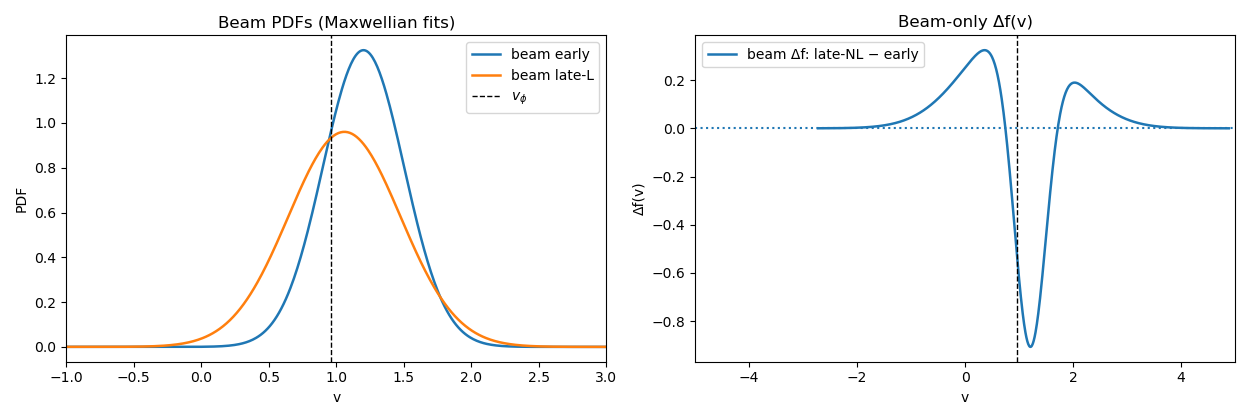

In [19]:
figC = plt.figure(figsize=(12.5, 4.2))

# Left panel: early vs late-linear Maxwellians
axC1 = figC.add_subplot(1, 2, 1)
axC1.plot(vg_grid, pdf_early_beam, lw=1.8, label='beam early')
axC1.plot(vg_grid, pdf_lateL_beam, lw=1.8, label='beam late-L')
axC1.axvline(v_phi, ls='--', color='k', lw=1.0, label=r'$v_\phi$')  # true phase velocity
axC1.set_xlim(-1,3) #(vg_min, vg_max)
axC1.set_xlabel('v')
axC1.set_ylabel('PDF')
axC1.set_title('Beam PDFs (Maxwellian fits)')
axC1.legend(loc='best')

# Right panel: Δf(v) = f_lateNL − f_early
axC2 = figC.add_subplot(1, 2, 2)
axC2.plot(vg_grid, pdf_lateNL_beam - pdf_early_beam, lw=1.8,
          label='beam Δf: late-NL − early')
axC2.axvline(v_phi, ls='--', color='k', lw=1.0)
axC2.axhline(0.0, ls=':')
axC2.set_xlim(-5,5) #(vg_min, vg_max)
axC2.set_xlabel('v')
axC2.set_ylabel('Δf(v)')
axC2.set_title('Beam-only Δf(v)')
axC2.legend(loc='best')

figC.tight_layout()
plt.show()

## Linear kinetic growth rate from the 2-Maxwellian dispersion relation

Instead of using a beam-only Landau estimate, we now compute the
linear growth rate $\gamma$ from the full kinetic dispersion relation for a
two-component electron plasma (background + beam), both modeled as
Maxwellians with the same parameters used in the simulation:

- background: density $n_{\text{bg}} = 1 - n_b$, mean 0, width `BG_STD`
- beam: density $n_b$, mean `ub`, width `vb`

The dielectric function is

$$
\varepsilon(\omega,k) = 1 + \chi_{\text{bg}} + \chi_{\text{b}},
$$

with

$$
\chi_j = \frac{\omega_{pj}^2}{k^2 v_{tj}^2}
\left[1 + \xi_j Z(\xi_j)\right],
\qquad
\xi_j = \frac{\omega/k - u_j}{v_{tj}},
$$

and $Z(\xi)$ the plasma dispersion function.

We take $\omega_{p,j}^2 \propto n_j$ in normalized units, so

- $\omega_{p,\text{bg}}^2 = 1 - n_b$
- $\omega_{p,\text{b}}^2 = n_b$

We then solve $\varepsilon(\omega,k) = 0$ for
$\omega = \omega_r + i\gamma$ near $\omega \approx \omega_p$, and
compare $\gamma$ to the value fitted from the exponential growth of $|E(t)|$.

In [20]:
def Z_plasma(xi):
    return 1j * np.sqrt(np.pi) * special.wofz(xi)

def epsilon_two_maxwellians(omega):
    n_b  = nb_true_f
    n_bg = 1.0 - nb_true_f

    wp_bg2 = n_bg
    wp_b2  = n_b

    vt_bg = BG_STD * np.sqrt(2.0)
    vt_b  = vb_f * np.sqrt(2.0)

    vph = omega / k

    xi_bg = (vph - 0.0) / vt_bg
    xi_b  = (vph - ub_f) / vt_b

    chi_bg = wp_bg2 / (k**2 * vt_bg**2) * (1.0 + xi_bg * Z_plasma(xi_bg))
    chi_b  = wp_b2  / (k**2 * vt_b**2)  * (1.0 + xi_b  * Z_plasma(xi_b))

    return 1.0 + chi_bg + chi_b

def solve_dispersion(omega_init, max_iter=50, tol=1e-10):
    omega = omega_init
    for it in range(max_iter):
        f  = epsilon_two_maxwellians(omega)
        h  = 1e-5
        fp = (epsilon_two_maxwellians(omega + h) -
              epsilon_two_maxwellians(omega - h)) / (2.0 * h)
        omega_new = omega - f / fp
        if abs(omega_new - omega) < tol:
            return omega_new, it + 1
        omega = omega_new
    return omega, max_iter

omega_guess = 1.0 + 0.05j
omega_root, iters = solve_dispersion(omega_guess)

omega_r      = omega_root.real
gamma_theory = omega_root.imag
gamma_fit    = fit_full['gamma'] if fit_full is not None else np.nan

print("=== Kinetic dispersion relation: 2-Maxwellian model ===")
print(f"k                = {k:.4f}")
print(f"nb_true          = {nb_true_f:.4f}")
print(f"BG_STD, vb       = {BG_STD:.4f}, {vb_f:.4f}")
print(f"Dispersion root  = ω = {omega_r:.6f} + i {gamma_theory:.6f}")
print(f"  (converged in {iters} iterations)")
print()
print("=== Linear growth rate comparison ===")
print(f"gamma_theory (DR) = {gamma_theory:.4e}")
print(f"gamma_fit (full)  = {gamma_fit:.4e}")
print(f"ratio fit/theory  = {gamma_fit/gamma_theory:.3f}")

NameError: name 'BG_STD' is not defined

In [21]:
def run_gamma_grid(N_beam, Nx_grid, dt, t0, t1, tmax, seed=42):
    """Run a beam-only simulation with grid scatter/gather and fit gamma on [t0,t1]."""
    rng_local = np.random.default_rng(seed)

    nb_true = float(PARAMS['nb_true'])
    ub      = float(PARAMS['ub'])
    vb      = float(PARAMS['vb'])
    E_amp0  = float(PARAMS['E_amp'])

    N_beam  = int(N_beam)
    Nx_grid = int(Nx_grid)
    dt      = float(dt)

    # init
    v = ub + vb * rng_local.standard_normal(N_beam)
    x = L * rng_local.random(N_beam)
    w = np.full(N_beam, nb_true / max(1, N_beam))

    xg = (np.arange(Nx_grid) + 0.5) * (L / Nx_grid)
    dx = L / Nx_grid

    # initial half-step
    E_amp = E_amp0
    E_grid = E_amp * np.cos(k * xg - omega_p * 0.0)
    E_p    = cic_gather(E_grid, x, L, dx)
    vhalf  = v - 0.5 * dt * (e_charge / m_e) * E_p

    nsteps = max(1, int(round(tmax / dt)))
    E_hist = np.empty(nsteps, dtype=float)
    t_hist = np.empty(nsteps, dtype=float)
    time   = 0.0

    for step in range(nsteps):
        E_hist[step] = abs(E_amp)
        t_hist[step] = time

        # field gather
        E_grid = E_amp * np.cos(k * xg - omega_p * time)
        E_p    = cic_gather(E_grid, x, L, dx)

        # leapfrog
        vhalf_new = vhalf - (e_charge / m_e) * E_p * dt
        v_cent    = 0.5 * (vhalf + vhalf_new)
        x = (x + vhalf_new * dt) % L

        # current -> grid -> mode projection
        Jp = w * v_cent
        Jg = cic_scatter(Jp, x, L, dx, Nx_grid) / dx
        J_k = (-e_charge) * (2.0 / L) * np.sum(Jg * np.cos(k * xg - omega_p * time)) * dx
        E_amp = E_amp - (e_charge / (m_e * omega_p)) * J_k * dt

        vhalf = vhalf_new
        time += dt

        if not np.isfinite(E_amp) or abs(E_amp) > 1e6:
            E_hist = E_hist[:step+1]
            t_hist = t_hist[:step+1]
            break

    # fit
    mask = (E_hist > 0.0)
    tt = t_hist[mask]
    yy = np.log(E_hist[mask])

    sel = (tt >= t0) & (tt <= t1)
    if np.count_nonzero(sel) < 8:
        return np.nan, np.nan

    tsel = tt[sel]
    ysel = yy[sel]
    A = np.vstack([tsel, np.ones_like(tsel)]).T
    c = np.linalg.lstsq(A, ysel, rcond=None)[0]
    gamma = c[0]
    yhat  = A @ c
    ssr = np.sum((ysel - yhat)**2)
    sst = np.sum((ysel - np.mean(ysel))**2)
    r2  = 1.0 - ssr / max(1e-12, sst)
    return gamma, r2


N=  2000, Nx=  64 -> gamma=9.6598e-02, R2=0.984
N=  4000, Nx=  64 -> gamma=5.9299e-02, R2=0.800
N=  8000, Nx=  64 -> gamma=5.6429e-02, R2=0.804
N= 16000, Nx=  64 -> gamma=7.8024e-02, R2=0.892
N= 32000, Nx=  64 -> gamma=1.2290e-01, R2=0.991
N= 64000, Nx=  64 -> gamma=1.2616e-01, R2=0.997
N=  2000, Nx= 128 -> gamma=9.6601e-02, R2=0.984
N=  4000, Nx= 128 -> gamma=5.9240e-02, R2=0.799
N=  8000, Nx= 128 -> gamma=5.6382e-02, R2=0.804
N= 16000, Nx= 128 -> gamma=7.7969e-02, R2=0.892
N= 32000, Nx= 128 -> gamma=1.2294e-01, R2=0.991
N= 64000, Nx= 128 -> gamma=1.2622e-01, R2=0.997
N=  2000, Nx= 256 -> gamma=9.6600e-02, R2=0.984
N=  4000, Nx= 256 -> gamma=5.9226e-02, R2=0.799
N=  8000, Nx= 256 -> gamma=5.6369e-02, R2=0.803
N= 16000, Nx= 256 -> gamma=7.7953e-02, R2=0.891
N= 32000, Nx= 256 -> gamma=1.2295e-01, R2=0.991
N= 64000, Nx= 256 -> gamma=1.2623e-01, R2=0.997
N=  2000, Nx= 512 -> gamma=9.6600e-02, R2=0.984
N=  4000, Nx= 512 -> gamma=5.9222e-02, R2=0.799
N=  8000, Nx= 512 -> gamma=5.6367e-02, R

,N_beam,Nx_grid,gamma,r2
0,2000,64,0.096598,0.983721
4,32000,64,0.122903,0.991142
5,64000,64,0.126156,0.997173
6,2000,128,0.096601,0.983611
10,32000,128,0.122943,0.991090
11,64000,128,0.126218,0.997153
12,2000,256,0.096600,0.983581
16,32000,256,0.122951,0.991076
17,64000,256,0.126233,0.997148
18,2000,512,0.096600,0.983574


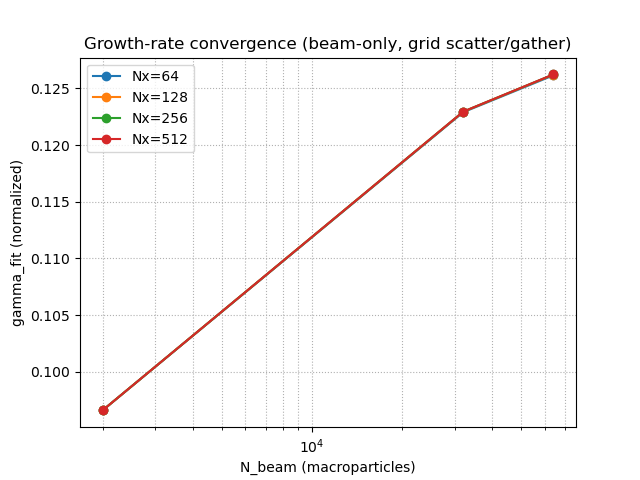

In [23]:
# ======================= Convergence study: growth rate ======================
# Choose a linear-fit window (use your previously identified one, or adjust)
t0_ref, t1_ref = 17.0, 50.0
tmax_scan      = 800.0

N_list   = [2000, 4000, 8000, 16000, 32000, 64000]
Nx_list  = [64, 128, 256, 512]

rows = []
for Nx in Nx_list:
    for N in N_list:
        g, r2 = run_gamma_grid(N_beam=N, Nx_grid=Nx, dt=PARAMS['dt'],
                               t0=t0_ref, t1=t1_ref, tmax=tmax_scan, seed=seed)
        rows.append(dict(N_beam=N, Nx_grid=Nx, gamma=g, r2=r2))
        print(f"N={N:6d}, Nx={Nx:4d} -> gamma={g:.4e}, R2={r2:.3f}")

df_conv = pd.DataFrame(rows)

# Keep only decent fits
df_good = df_conv[(df_conv['r2'] >= 0.90) & np.isfinite(df_conv['gamma'])].copy()
display(df_good)

# Simple visualization: gamma vs N for each Nx
plt.figure()
for Nx in Nx_list:
    sub = df_good[df_good['Nx_grid']==Nx]
    if len(sub)==0: 
        continue
    plt.plot(sub['N_beam'], sub['gamma'], marker='o', label=f"Nx={Nx}")
plt.xscale('log')
plt.xlabel('N_beam (macroparticles)')
plt.ylabel('gamma_fit (normalized)')
plt.title('Growth-rate convergence (beam-only, grid scatter/gather)')
plt.grid(True, which='both', ls=':')
plt.legend()
plt.show()


=== Kinetic dispersion relation: 2-Maxwellian model === 
k = 1.0417 
nb_true = 0.1000 
BG_STD, vb = 0.6000, 0.3000 
Dispersion root = ω = 0.913381 + i -0.036436 
(converged in 6 iterations) 

=== Linear growth rate comparison === 
gamma_theory (DR) = 3.6436e-02 
gamma_fit (full) = 1.9321e-02 
ratio fit/theory = 0.530



# Next steps
- Gamma values vs number of particles
- Gamma values vs time steps (dt)
- Check the dimensions of gamma and see if it checks with the theoretical

,N_beam,Nx_grid,gamma,R2
0,2000,256,0.008341,0.994563
1,4000,256,0.007876,0.995194
2,8000,256,0.007872,0.995234
3,16000,256,0.008015,0.995133
4,32000,256,0.008339,0.995233
5,64000,256,0.008464,0.995044


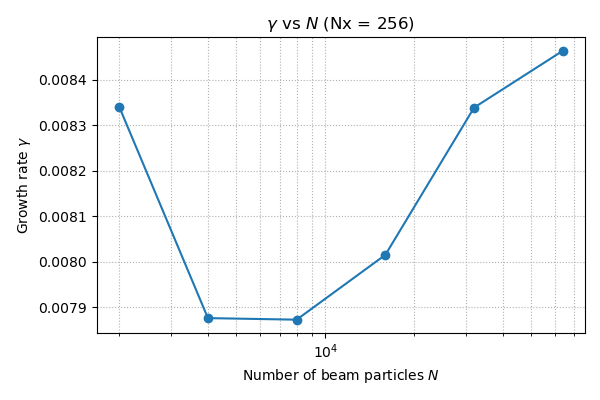

In [24]:
# ============================================================
# Resolution scan: growth rate gamma vs number of particles N
# (Nx fixed)
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt

# --- USER CONTROLS ---
Nx_fixed   = 256                      # keep grid resolution fixed
N_list    = [2000, 4000, 8000, 16000, 32000, 64000]
t0_fit    = 125.0                    # start of linear-fit window
t1_fit    = 260.0                    # end of linear-fit window
tmax_scan = 800.0                    # total simulation time
dt_scan   = PARAMS["dt"]             # use notebook dt
seed_scan = seed                     # reuse notebook seed

# --- RUN SCAN ---
rows = []

for N in N_list:
    gamma, r2 = run_gamma_grid(
        N_beam=N,
        Nx_grid=Nx_fixed,
        dt=dt_scan,
        t0=t0_fit,
        t1=t1_fit,
        tmax=tmax_scan,
        seed=seed_scan
    )

    rows.append({
        "N_beam": N,
        "Nx_grid": Nx_fixed,
        "gamma": gamma,
        "R2": r2
    })

df_gamma_N = pd.DataFrame(rows)

# --- DISPLAY TABLE ---
display(df_gamma_N)

# --- PLOT ---
plt.figure(figsize=(6,4))
plt.plot(df_gamma_N["N_beam"], df_gamma_N["gamma"], marker="o")
plt.xscale("log")
plt.xlabel("Number of beam particles $N$")
plt.ylabel("Growth rate $\\gamma$")
plt.title(f"$\\gamma$ vs $N$ (Nx = {Nx_fixed})")
plt.grid(True, which="both", ls=":")
plt.tight_layout()
plt.show()


,dt,N_beam,Nx_grid,gamma,R2
0,0.40,32000,256,0.009743,0.985809
1,0.30,32000,256,0.009990,0.987405
2,0.20,32000,256,0.009846,0.989471
3,0.15,32000,256,0.009424,0.991784
4,0.10,32000,256,0.008339,0.995233
5,0.08,32000,256,0.007559,0.996430
6,0.06,32000,256,0.006471,0.997447
7,0.05,32000,256,0.005798,0.997311


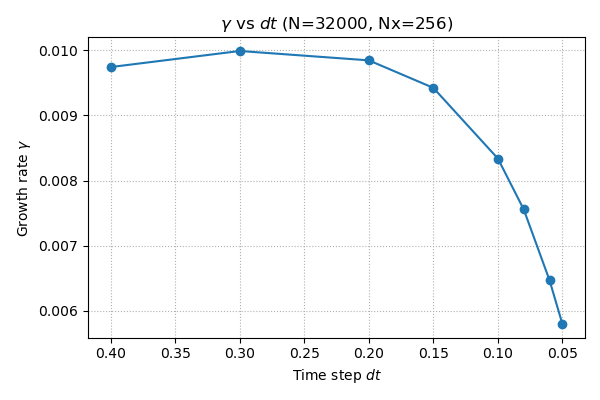

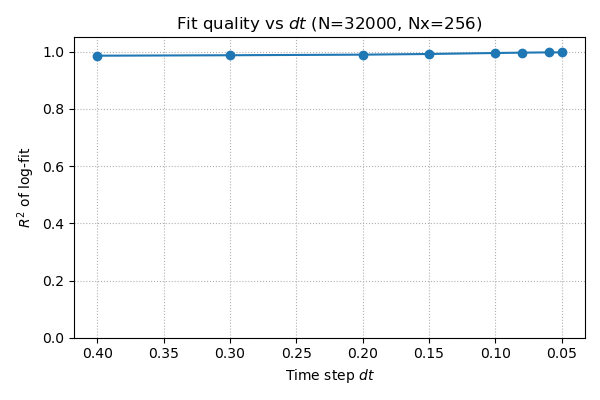

In [25]:
# ============================================================
# Resolution scan: growth rate gamma vs time step dt
# (N and Nx fixed)
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt

# --- USER CONTROLS ---
N_fixed    = 32000                    # fix particle count (pick a "large enough" N)
Nx_fixed   = 256                      # fix grid resolution
dt_list    = [0.40, 0.30, 0.20, 0.15, 0.10, 0.08, 0.06, 0.05]
t0_fit     = 125.0                    # start of fit window
t1_fit     = 260.0                    # end of fit window
tmax_scan  = 800.0                    # keep the same physical end-time across dt
seed_scan  = seed                     # reuse notebook seed

# --- RUN SCAN ---
rows = []

for dt_test in dt_list:
    gamma, r2 = run_gamma_grid(
        N_beam=N_fixed,
        Nx_grid=Nx_fixed,
        dt=dt_test,
        t0=t0_fit,
        t1=t1_fit,
        tmax=tmax_scan,
        seed=seed_scan
    )

    rows.append({
        "dt": dt_test,
        "N_beam": N_fixed,
        "Nx_grid": Nx_fixed,
        "gamma": gamma,
        "R2": r2
    })

df_gamma_dt = pd.DataFrame(rows).sort_values("dt", ascending=False).reset_index(drop=True)

# --- DISPLAY TABLE ---
display(df_gamma_dt)

# --- PLOTS ---
# 1) gamma vs dt
plt.figure(figsize=(6,4))
plt.plot(df_gamma_dt["dt"], df_gamma_dt["gamma"], marker="o")
plt.gca().invert_xaxis()  # smaller dt to the right is often easier to read
plt.xlabel("Time step $dt$")
plt.ylabel("Growth rate $\\gamma$")
plt.title(f"$\\gamma$ vs $dt$ (N={N_fixed}, Nx={Nx_fixed})")
plt.grid(True, ls=":")
plt.tight_layout()
plt.show()

# 2) R2 vs dt (diagnostic: fit quality)
plt.figure(figsize=(6,4))
plt.plot(df_gamma_dt["dt"], df_gamma_dt["R2"], marker="o")
plt.gca().invert_xaxis()
plt.xlabel("Time step $dt$")
plt.ylabel("$R^2$ of log-fit")
plt.title(f"Fit quality vs $dt$ (N={N_fixed}, Nx={Nx_fixed})")
plt.ylim(0, 1.05)
plt.grid(True, ls=":")
plt.tight_layout()
plt.show()
